## Basic analysis of tracking data from CsChrimson experiments in free walking arena

#### Note: This script should be used for data collected using the a stimulation protocol generated byoptogeneticsProtocol_basic.py

In [1]:
from scipy.io import loadmat
import csv
import matplotlib.colors as colors
import numpy as np
import seaborn as sns
from scipy import sparse as sps

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import gridspec
#plt.style.use('ggplot')

%matplotlib inline

### Set experiment parameter

In [2]:
baseDir = '/Volumes/jayaramanlab/Hannah/OptogeneticsFreeWalkingArena/1_Data/rewardNeuronScreen'

genotype = '20xCsChr_x_MB022B'
experiment = 'vial1_trial1'
fileName = '20xCsChr_x_MB022B_vial1_trial1_cam_0_date_2015_06_11_time_20_05_05_v001'

expName = '(' + genotype + ', ' + experiment + ')'


fps = 30 # Video sampling rate
imageSizePx = (1000,1000) #size of the recorded frames in pixel
 
# Continuous full-field stimulation
stimSecC = 5
pauseSecC = 25
numRepeatC = 2
stimStartFrameC = 414#375

# Pulsed full-field stimulation
stimSecP = 10
pauseSecP = 20
numRepeatP = 2
stimStartFrameP = stimStartFrameC + fps*numRepeatC*(stimSecC + pauseSecC) #2180

# Quadrant (continuous) stimulation
stimSecQ = 50
pauseSecQ = 10
numRepeatQ = 4 #2 x 2 patterns
stimStartFrameQ = stimStartFrameP + fps*numRepeatP*(stimSecP + pauseSecP) #3977

pixel2mm = 900/225 # Only estimated, NEED TO MEASURE THIS

In [230]:
stimStartFrameP

2214

In [231]:
stimStartFrameQ

4014

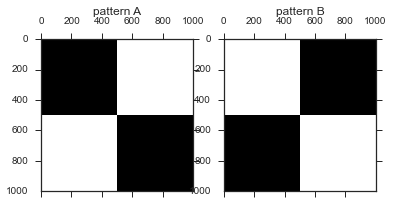

In [238]:
# Define masks (for the moment assume that arena is perfectly centered and 
# that quadrants are squares. Need to read in image frame and extract shapes by using edges.)

LEDon = np.ones((imageSizePx[0]/2,imageSizePx[1]/2))
LEDoff = np.zeros((imageSizePx[0]/2,imageSizePx[1]/2))

# first stimulation pattern
patternA = np.hstack((np.vstack((LEDon,LEDoff)),np.vstack((LEDoff,LEDon))))

# second stimulation pattern
patternB = np.hstack((np.vstack((LEDoff,LEDon)),np.vstack((LEDon,LEDoff))))

patternFig = plt.figure()
ax1 = patternFig.add_subplot(121); plt.spy(patternA); ax1.set_title('pattern A\n')
ax2 =patternFig.add_subplot(122); plt.spy(patternB); ax2.set_title('pattern B\n')


### Import and rearrange data

In [232]:
keyList = ['timestamps','x_pos','y_pos','ntargets','identity','angle'] #data columns to be extracted from ctrax file

try:
    #load existing python file
    npzData = np.load(baseDir + '/' + genotype + '/' + fileName + '.npz')
    xPos = npzData['xPos']
    yPos = npzData['yPos']
    angle = npzData['angle']
    flyID = npzData['flyID']
    numFrames = len(xPos)
    
except:
    #load matlab data and convert
    indat = loadmat(baseDir + '/' + genotype + '/' + genotype + '_' + experiment + '/' + fileName + '.mat')

    dat = [indat[k] for k in keyList]
    
    # Reorganise fly position arrays into lists (sorted by frame)
    numFrames = len(dat[0])
    xPos = []
    yPos = []
    angle = []
    flyID = []

    pointer = 0
    for t in range(numFrames):
        numFlies = dat[3][t].astype('int')[0]
    
        xPos.append(dat[1][pointer:pointer+numFlies])
        yPos.append(dat[2][pointer:pointer+numFlies])
        angle.append(dat[5][pointer:pointer+numFlies])
        flyID.append(dat[4][pointer:pointer+numFlies])

        pointer += numFlies
    
    xPos = np.array(xPos)
    yPos = np.array(yPos)
    angle = np.array(angle)
    flyID = np.array(flyID)
    maxFlyID = max(dat[4])
    
    #save data for future sessions
    np.savez(baseDir + '/' + genotype + '/' + genotype + '_' + experiment + '/' + fileName + '.npz', xPos=xPos, yPos=yPos, angle=angle, flyID=flyID,maxFlyID=maxFlyID)

### Visualise tracking performance

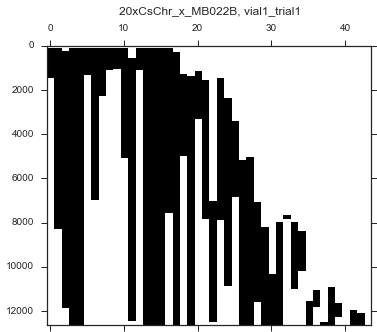

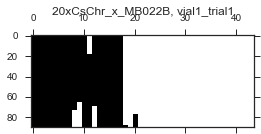

(0, array([ 43.]))

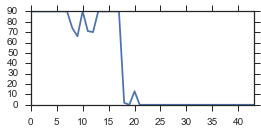

In [233]:
# Reorganise fly track fragments into matrix (frame x fly id )
flyIDperFrame = np.zeros((numFrames,maxFlyID+1))
for frame in range(numFrames):
    for idx in np.array(flyID[frame]).squeeze().astype('int'):
        flyIDperFrame[frame][idx] = 1

#visualise resluting matrix
fig = plotSparseMatrix((7,5),0.003,flyIDperFrame, genotype + ', ' + experiment + '\n')

fig.savefig(baseDir 
            + '/' + genotype + '/' + genotype + '_' + experiment + '/' + fileName + '_traceFragments.pdf', format = 'pdf')

startFrame = stimStartFrameC
frameRange = range(startFrame+0*fps,startFrame+(stimSecC+pauseSecC)*fps,10)
FOI = flyIDperFrame[frameRange]#frames of interest

#visualise frames of interest (FOI) matrix
fig = plotSparseMatrix((4,4),0.2,FOI,genotype + ', ' + experiment + '\n');

fig = plt.figure(figsize = (4,4))
ax = fig.add_subplot(111)
ax.plot(sum(FOI))
ax.set_aspect(0.2)
plt.xlim(0,max(dat[4]))

### Plot traces for each stimulation block (colour-coded time)

In [235]:
#set frameBlocks

skipFramesOFF = 3
skipFramesON = 3

#continuous protocol
chrContinuous = np.array([[stimStartFrameC,stimStartFrameC+stimSecC*fps,skipFramesON],
                          [stimStartFrameC+stimSecC*fps,stimStartFrameC+(stimSecC+pauseSecC)*fps,skipFramesOFF],
                          [stimStartFrameC+(stimSecC+pauseSecC)*fps,stimStartFrameC+(2*stimSecC+pauseSecC)*fps,skipFramesON],
                          [stimStartFrameC+(2*stimSecC+pauseSecC)*fps,stimStartFrameC+(2*stimSecC+2*pauseSecC)*fps,skipFramesOFF]])
chrContinuousColor = ['Reds','PuBu','Reds','PuBu']

#pulsed protocol
chrPulsed = np.array([[stimStartFrameP,stimStartFrameP+stimSecP*fps,skipFramesON],
                      [stimStartFrameP+stimSecP*fps,stimStartFrameP+(stimSecP+pauseSecP)*fps,skipFramesOFF],
                      [stimStartFrameP+(stimSecP+pauseSecP)*fps,stimStartFrameP+(2*stimSecP+pauseSecP)*fps,skipFramesON],
                      [stimStartFrameP+(2*stimSecP+pauseSecP)*fps,stimStartFrameP+(2*stimSecP+2*pauseSecP)*fps,skipFramesOFF]])
chrPulsedColor = ['Reds','PuBu','Reds','PuBu']

#quadrant protocol
chrQuadrant = np.array([[stimStartFrameQ,stimStartFrameQ+stimSecQ*fps,skipFramesON],
                        [stimStartFrameQ+stimSecQ*fps,stimStartFrameQ+(stimSecQ+pauseSecQ)*fps,skipFramesOFF],
                        [stimStartFrameQ+(stimSecQ+pauseSecQ)*fps,stimStartFrameQ+(2*stimSecQ+pauseSecQ)*fps,skipFramesON],
                        [stimStartFrameQ+(2*stimSecQ+pauseSecQ)*fps,stimStartFrameQ+(2*stimSecQ+2*pauseSecQ)*fps,skipFramesOFF],
                        [stimStartFrameQ+(2*stimSecQ+2*pauseSecQ)*fps,stimStartFrameQ+(3*stimSecQ+2*pauseSecQ)*fps,skipFramesON],
                        [stimStartFrameQ+(3*stimSecQ+2*pauseSecQ)*fps,stimStartFrameQ+(3*stimSecQ+3*pauseSecQ)*fps,skipFramesOFF],
                        [stimStartFrameQ+(3*stimSecQ+3*pauseSecQ)*fps,stimStartFrameQ+(4*stimSecQ+3*pauseSecQ)*fps,skipFramesON],
                        [stimStartFrameQ+(4*stimSecQ+3*pauseSecQ)*fps,stimStartFrameQ+(4*stimSecQ+4*pauseSecQ)*fps,skipFramesOFF]])
chrQuadrantColor = ['Reds','PuBu','Reds','PuBu','Reds','PuBu','Reds','PuBu']

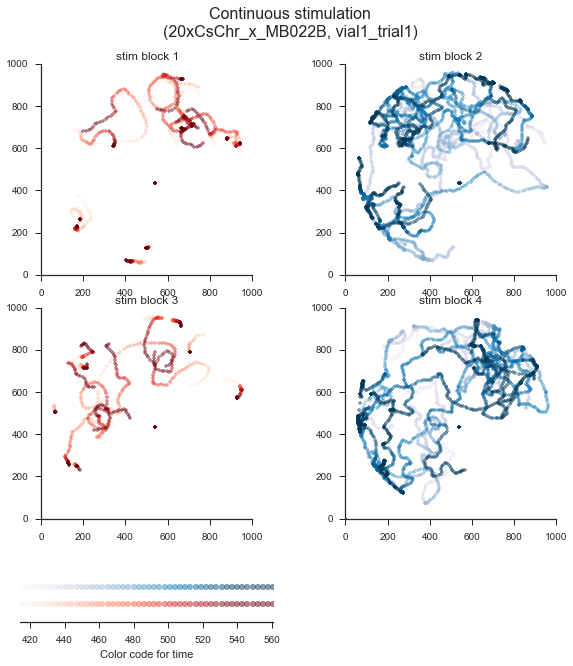

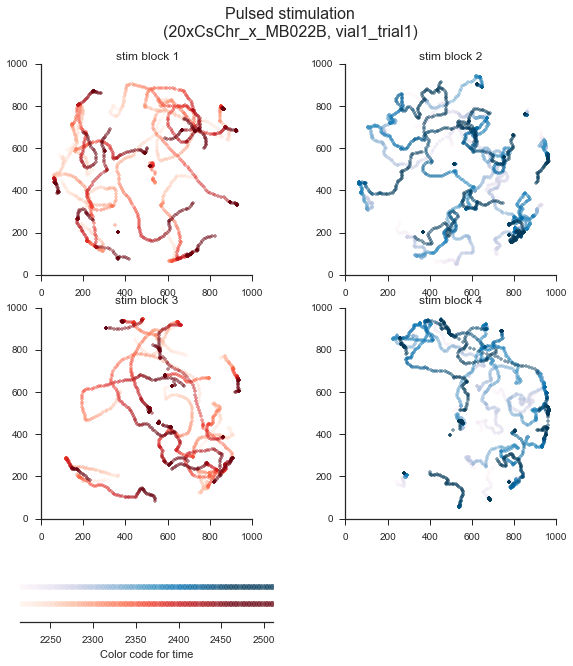

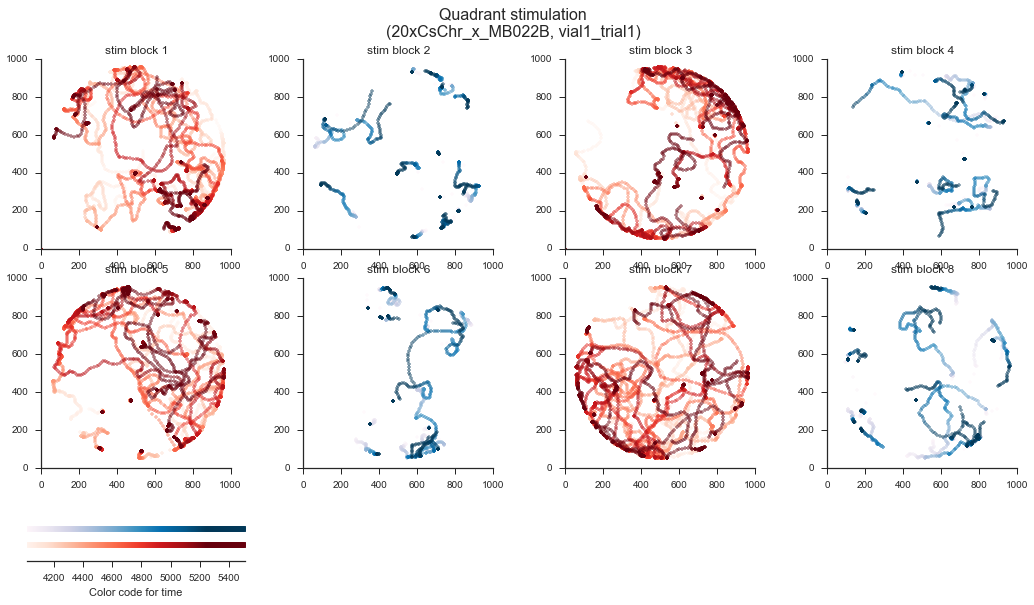

In [236]:
figC = plotStimulationBlock_timeBar(chrContinuous,chrContinuousColor,
                                    'Continuous stimulation\n' + expName ,(10,10),2)
figC.savefig(baseDir + '/' + genotype + '/' + genotype + '_' + experiment + '/' + fileName + '_continuousTrace.pdf', format = 'pdf')
figP = plotStimulationBlock_timeBar(chrPulsed,chrPulsedColor,
                                    'Pulsed stimulation\n' + expName,(10,10),2)
figP.savefig(baseDir + '/' + genotype + '/' + genotype + '_' + experiment + '/' + fileName + '_pulsedTrace.pdf', format = 'pdf')
figQ = plotStimulationBlock_timeBar(chrQuadrant,chrQuadrantColor,
                                    'Quadrant stimulation\n' + expName,(18,9),4)
figQ.savefig(baseDir + '/' + genotype + '/' + genotype + '_' + experiment + '/' + fileName + '_quadrantTrace.pdf', format = 'pdf')

### Detailed traces during the 4 quadrant trials

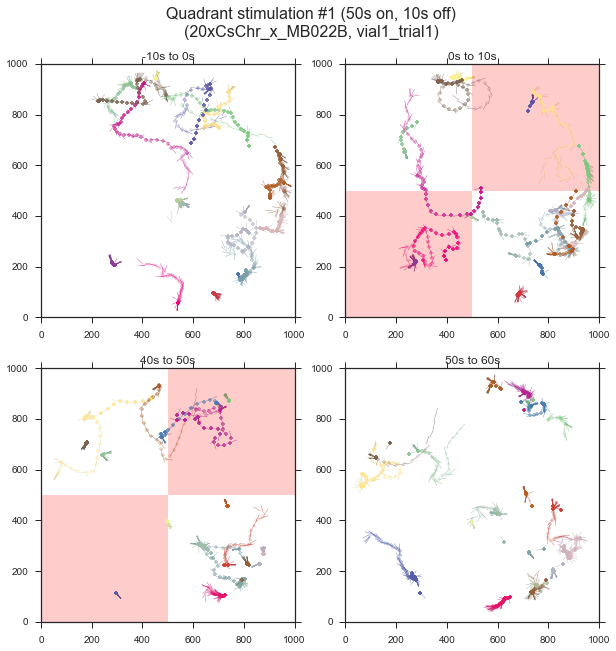

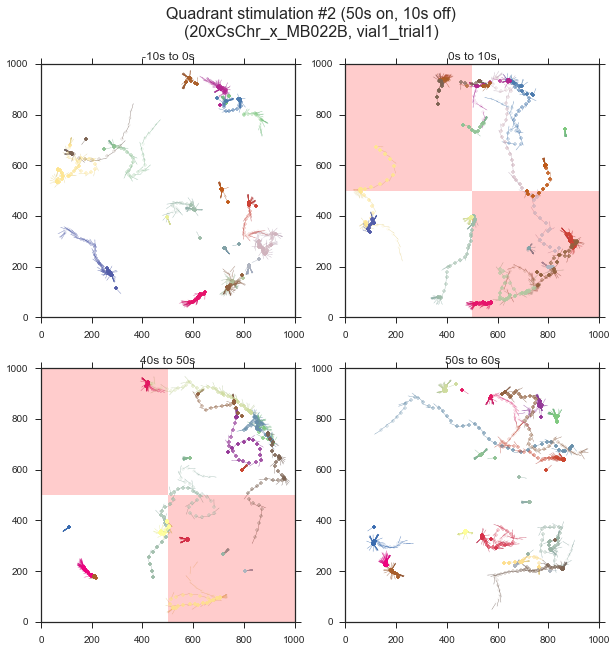

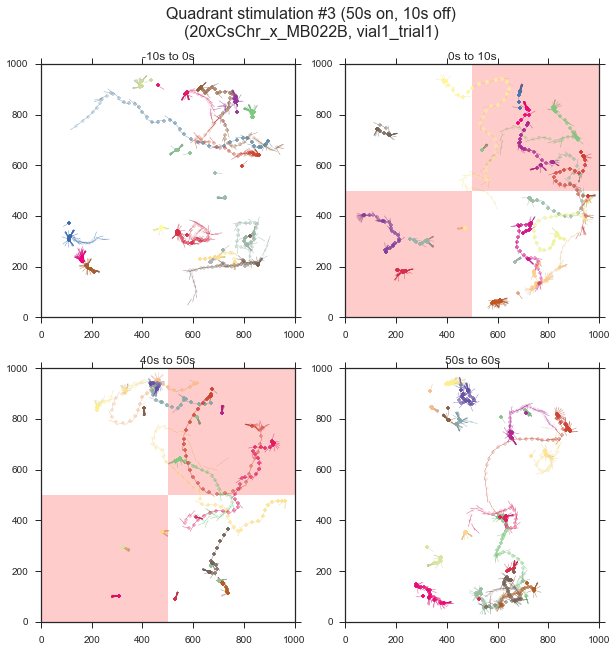

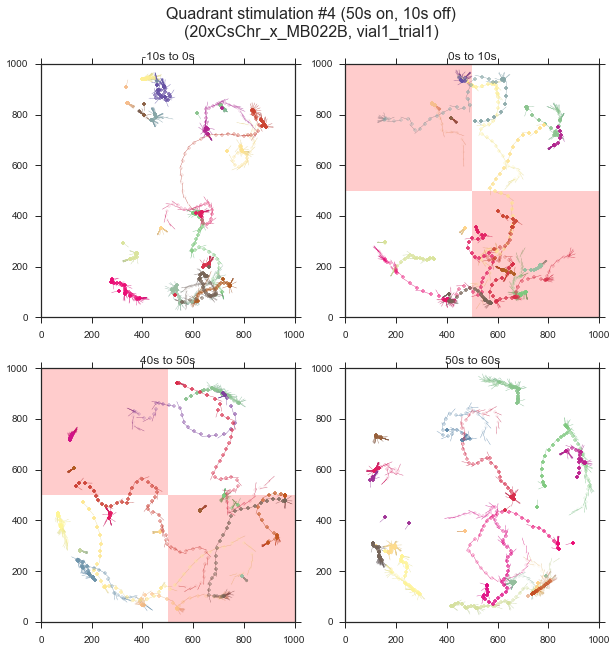

In [247]:
timeWindow = 10
figSize = (10,10)

#Quadrant Repeats 1 to 4
for quadrantRepeat in range(1,5):
    startFrame = stimStartFrameQ+(quadrantRepeat-1)*(stimSecQ+pauseSecQ)*fps
    fig = plt.figure(figsize = figSize)
    fig.suptitle('Quadrant stimulation #'+str(quadrantRepeat)+' ('+str(stimSecQ)+'s on, '+str(pauseSecQ)+'s off)\n' + expName ,fontsize = 16)

    #arena = plt.Circle((500,500), 485, color = 'grey')

    for i in range(2):
        frameRange = range(startFrame+(i*stimSecQ-timeWindow)*fps,startFrame+(i*stimSecQ)*fps,6)
        FOI = flyIDperFrame[frameRange]#frames of interest
        activeFragments = np.array(np.nonzero(sum(FOI))).squeeze()
        titleString = str(i*stimSecQ-timeWindow) + 's to ' + str(i*stimSecQ) +'s'
        
        subplt = fig.add_subplot(2,2,2*i+1)
        plotActiveSegments(activeFragments,subplt,titleString,xPos,yPos,angle,flyID)
        if(i==1):
            if((quadrantRepeat)%2 == 1):
                lightONindicator(subplt,0, 0, imageSizePx[0]/2, imageSizePx[1]/2)
                lightONindicator(subplt,imageSizePx[0]/2, imageSizePx[1]/2, imageSizePx[0]/2, imageSizePx[1]/2)
            else:
                lightONindicator(subplt,0, imageSizePx[0]/2, imageSizePx[0]/2, imageSizePx[1]/2)
                lightONindicator(subplt,imageSizePx[0]/2, 0, imageSizePx[0]/2, imageSizePx[1]/2)
        #subplt.add_artist(arena)
        
        frameRange = range(startFrame+(i*stimSecQ)*fps,startFrame+(i*stimSecQ+timeWindow)*fps,6)
        FOI = flyIDperFrame[frameRange]#frames of interest
        activeFragments = np.array(np.nonzero(sum(FOI))).squeeze()
        titleString = str(i*stimSecQ) + 's to ' + str(i*stimSecQ+timeWindow) +'s'

        subplt = fig.add_subplot(2,2,2*i+2)
        plotActiveSegments(activeFragments,subplt,titleString,xPos,yPos,angle,flyID)
        if(i==0):
            if((quadrantRepeat)%2 == 1):
                lightONindicator(subplt,0, 0, imageSizePx[0]/2, imageSizePx[1]/2)
                lightONindicator(subplt,imageSizePx[0]/2, imageSizePx[1]/2, imageSizePx[0]/2, imageSizePx[1]/2)
            else:
                lightONindicator(subplt,0, imageSizePx[0]/2, imageSizePx[0]/2, imageSizePx[1]/2)
                lightONindicator(subplt,imageSizePx[0]/2, 0, imageSizePx[0]/2, imageSizePx[1]/2)
        #subplt.add_artist(arena)
        
    
    fig.savefig(baseDir + '/' + genotype + '/' + genotype + '_' + experiment + '/' + fileName + '_detail_quadrantRepeat' + str(quadrantRepeat) + '.pdf', format = 'pdf')

### Percent of flies per quadrant

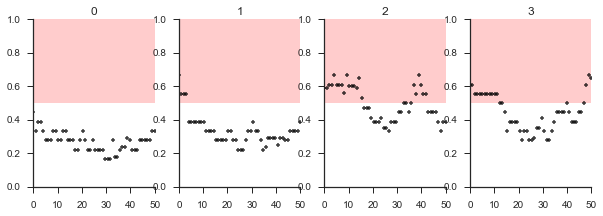

In [246]:
quadFractionFig = plt.figure(figsize=(10,3))
numQuadRepeat = 4

for quadrantRepeat in range(numQuadRepeat):
    
    startFrame = stimStartFrameQ + quadrantRepeat*(stimSecQ+pauseSecQ)*fps
    
    if(quadrantRepeat%2 == 0):
        ONpattern = patternA
    else:
        ONpattern = patternB

    frameRange = range(startFrame,startFrame + stimSecQ*fps,30)
    time = np.linspace(0,stimSecQ,len(frameRange))
    
    fliesInLEDon = np.zeros((len(frameRange),1))
    fractionInLEDon = np.zeros((len(frameRange),1))

    indCounter = 0
    for frame in frameRange:
        #assemble fly positions for frame
        spsData = np.ones((len(xPos[frame]),1)).squeeze()
        spsColInds = np.array(xPos[frame].astype('int').squeeze())
        spsRowInds = np.array(yPos[frame].astype('int').squeeze())
    
        flyLocations = sps.coo_matrix((spsData, (spsRowInds, spsColInds)), shape=(imageSizePx[0],imageSizePx[1])).toarray()
    
        #check in wich pattern flies appear
        fliesInONpattern = (ONpattern + flyLocations)>1
        fliesInLEDon[indCounter] = sum(sum(fliesInONpattern))
        fractionInLEDon[indCounter] = sum(sum(fliesInONpattern))/sum(sum(flyLocations))
    
        indCounter += 1
        #plt.figure(figsize=(10,10))
        #plt.spy(tempMat)
        
    subplt = quadFractionFig.add_subplot(1,numQuadRepeat,quadrantRepeat+1)
    subplt.plot(time,fractionInLEDon, marker = '.', linestyle = 'none', color = 'black',alpha = 0.75)
    lightONindicator(subplt,0, 0.5, stimSecQ, 0.5)

    sns.despine(right=True,offset = 0)#trim=True)
    sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})
    subplt.set_title(quadrantRepeat)
    subplt.set_ylim((0,1)) 

quadFractionFig.savefig(baseDir + '/' + genotype + '/' + genotype + '_' + experiment + '/' + fileName + '_fractionInLEDon.pdf', format = 'pdf')

In [244]:
def lightONindicator(subplt,x,y,width,height):
    subplt.add_patch(
        patches.Rectangle(
             (x,y), width, height,
            alpha = 0.2, facecolor = 'red', edgecolor = 'none'
        )
    )

#### Function definitions (in order of apprearance)

In [17]:
def plotSparseMatrix(figsize,aspectRatio,matrixToPlot,titleString):
    fig = plt.figure(figsize = figsize)
    fig.set_canvas(plt.gcf().canvas)
    sns.set_style('ticks')
    ax = fig.add_subplot(111)
    ax.spy(matrixToPlot)
    ax.set_aspect(aspectRatio)
    ax.set_title(titleString)
    sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})
    plt.show()
    
    return fig

In [18]:
def plotPosInRange(ax,frameRange,xPos,yPos,currCmap):
    cNorm  = colors.Normalize(vmin=0, vmax=2.5*len(frameRange))
    scalarMap = plt.cm.ScalarMappable(norm=cNorm,cmap=currCmap)
    
    [ax.plot(xPos[frame],yPos[frame],marker='.',linestyle='none',alpha=0.5, color=scalarMap.to_rgba(frame-frameRange[0])) 
     for frame in frameRange];
    
    ax.set_aspect('equal')
    sns.despine(right=True,offset = 0)#trim=True)
    sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})
    
    plt.xlim([0,1000]);
    plt.ylim([0,1000]);

In [30]:
def plotStimulationBlock(blockFrames,blockColors,title,figureSize,colNumber):
    blockfig = plt.figure(figsize = figureSize)
    blockfig.set_canvas(plt.gcf().canvas)
    sns.set_style('ticks')
    blockfig.suptitle(title,fontsize = 16)
    
    for block in range(len(blockFrames)):
        frames = range(blockFrames[block][0],blockFrames[block][1],blockFrames[block][2])
        subplt = blockfig.add_subplot(len(blockFrames)/colNumber,colNumber,block+1)
        plotPosInRange(subplt,frames,xPos,yPos,blockColors[block])
        subplt.set_title('stim block ' + str(block+1))
    
    return blockfig

In [31]:
def plotStimulationBlock_timeBar(blockFrames,blockColors,title,figureSize,colNumber):
    fig = plt.figure(figsize = figureSize)
    fig.set_canvas(plt.gcf().canvas)
    sns.set_style('ticks')
    fig.suptitle(title,fontsize = 16)
    
    gs = gridspec.GridSpec(len(blockFrames)/colNumber + 1 ,colNumber, height_ratios=[3,3,1]) 

    for block in range(len(blockFrames)):
        frames = range(blockFrames[block][0],blockFrames[block][1],blockFrames[block][2])
        subplt = fig.add_subplot(gs[block])
        plotPosInRange(subplt,frames,xPos,yPos,blockColors[block])
        subplt.set_title('stim block ' + str(block+1))
        
    #time color code
    timeplt = fig.add_subplot(gs[block+1])
    frameRange = range(blockFrames[0][0],blockFrames[0][1],blockFrames[0][2])
    
    cNorm  = colors.Normalize(vmin=0, vmax=2.5*len(frameRange))
    scalarMap = plt.cm.ScalarMappable(norm=cNorm,cmap=blockColors[0])
    
    [timeplt.plot(frame,1,marker='.',markersize=12,linestyle='none',alpha=0.5,
                  color=scalarMap.to_rgba(frame-frameRange[0])) 
     for frame in frameRange];
    
    scalarMap = plt.cm.ScalarMappable(norm=cNorm,cmap=blockColors[1])
    [timeplt.plot(frame,1.5,marker='.',markersize=12,linestyle='none',alpha=0.5,
                  color=scalarMap.to_rgba(frame-frameRange[0])) 
     for frame in frameRange];
    #timeplt.set_aspect(13) 
    timeplt.get_xaxis().tick_bottom()
    timeplt.get_yaxis().set_visible(False)
    timeplt.spines['top'].set_visible(False)
    timeplt.spines['right'].set_visible(False)
    timeplt.spines['left'].set_visible(False)
    plt.xlim([frameRange[0],frameRange[-1]]);
    plt.ylim([0.5,2.5]);
    plt.xlabel('Color code for time')
    
    return fig

In [21]:
def plotActiveSegments(activeFragments,subplt,titleString,xPos,yPos,angle,flyID):
    
    flyRange = range(min(activeFragments),max(activeFragments)+1)

    cNorm  = colors.Normalize(vmin=min(activeFragments), vmax=max(activeFragments+1))
    scalarMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Accent')

    arrowScale = 5
    
    for currFly in flyRange:
        counter = 0.0
        for frame in frameRange:
            currX = xPos[frame][flyID[frame] == currFly]
            currY = yPos[frame][flyID[frame] == currFly]
            
            try:
                newArrow = patches.Arrow(currX.squeeze(), currY.squeeze(), np.cos(angle[frame][flyID[frame] == currFly]).squeeze()*30,
                                         np.sin(angle[frame][flyID[frame] == currFly]).squeeze()*30, width=2,
                                         edgecolor = scalarMap.to_rgba(currFly),alpha = 0.5)
                subplt.add_patch(newArrow)
            except:
                continue
                
            subplt.plot(currX,currY, marker='.',color=scalarMap.to_rgba(currFly), markersize=8,
                        alpha = 1-counter/(len(frameRange)))
            
            counter +=1.0
    subplt.set_aspect('equal')
    subplt.set_title(titleString) 
    
    subplt.set_xlim((0,1000))
    subplt.set_ylim((0,1000))